In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# モジュールのインポート
import os
import json
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import sys
import pickle

In [3]:
# 自作モジュール
sys.path.append("../")
from module_extraction import Filters, Modules
import module_extraction

In [4]:
#os.environ["OMP_NUM_THREADS"] = "4"

分析対象の指定

In [5]:
# --オルソ画像 --
#input_img_path = 'images/ortho/1391.tif'
#input_img_path = 'images/ortho/1477.tif'
input_img_path = '../images/ortho/1466.tif'
#input_img_path = 'images/ortho/1480.tif'

#input_img_path = 'images/ortho/1411.tif'
#input_img_path = 'images/ortho/1481.tif'
#input_img_path = 'images/ortho/1441.tif'
#input_img_path = 'images/ortho/1473.tif'

In [6]:
# 出力先フォルダの作成
output_dir_path = "../outputs/"+input_img_path.split("/")[-1][:-4]
print(output_dir_path)
os.makedirs(output_dir_path,exist_ok=True)

../outputs/1466


フィルタの適用

In [7]:
filters = Filters()

In [8]:
# 元画像
img_org = cv2.imread(input_img_path, 0)
module_extraction.show_img({"modules":img_org},cmap="gray",figsize=(30,30))

../module_extraction.py:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


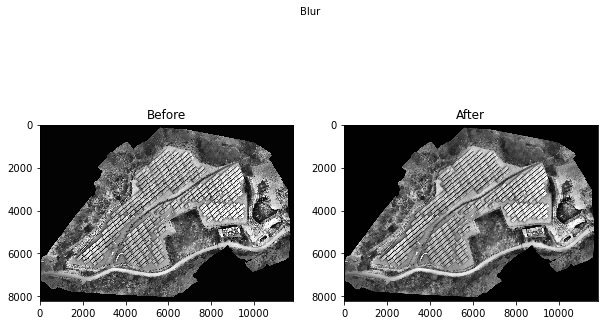

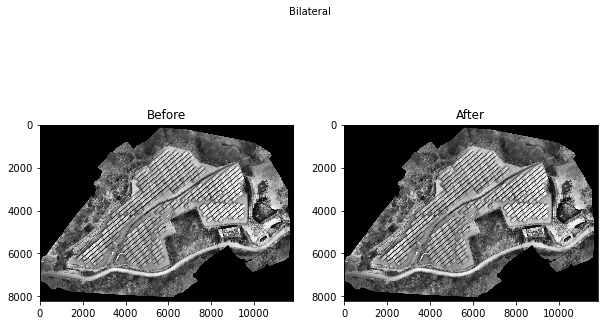

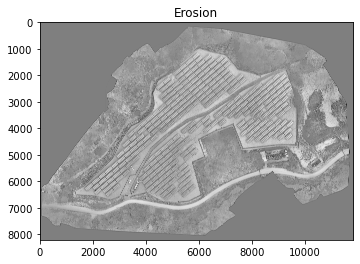

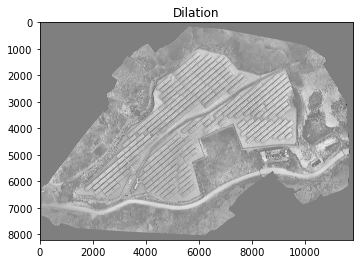

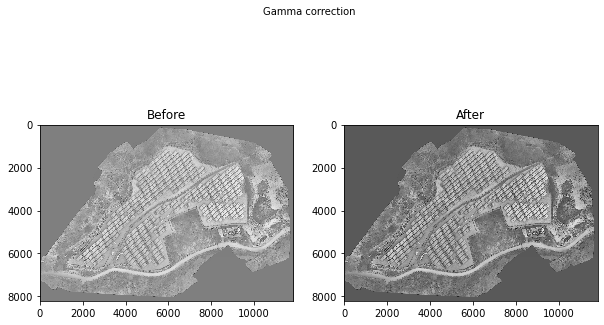

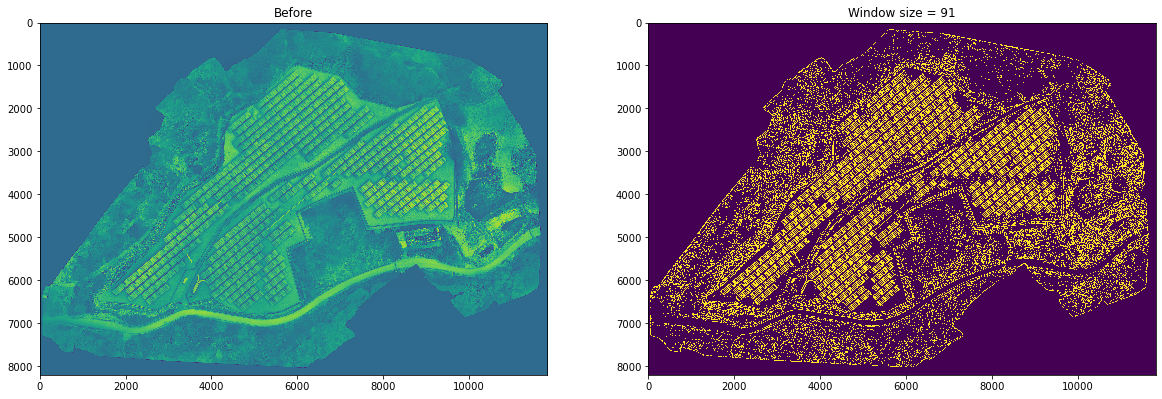

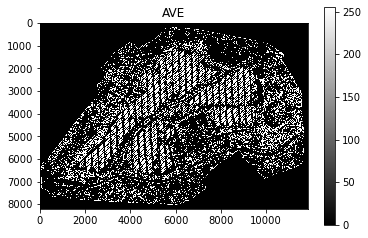

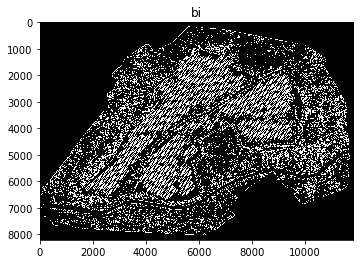

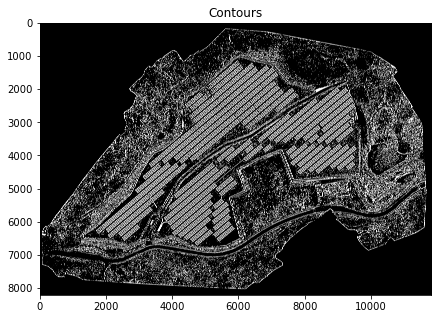

In [9]:
# 前処理
candidate_module_contours = filters.get_module_contours(img_org)

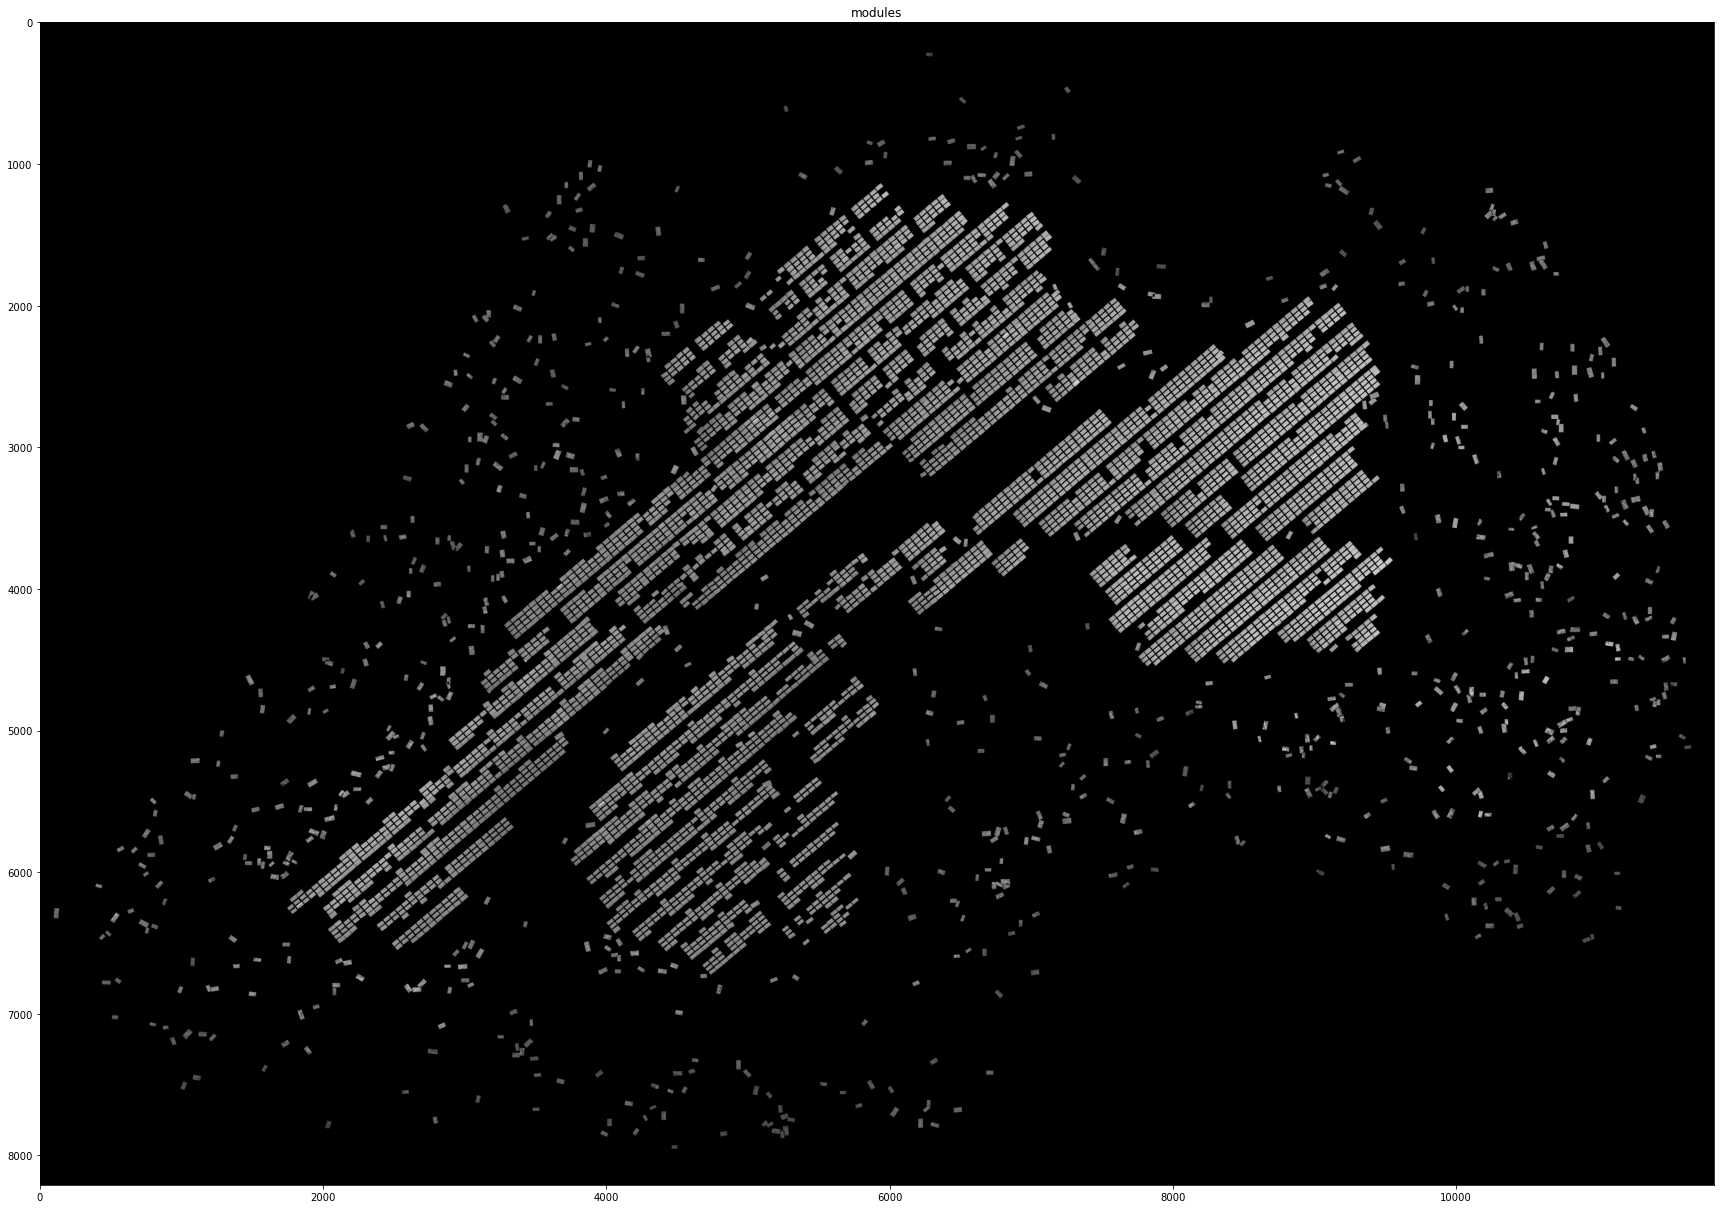

In [10]:
# モジュール抽出画像
img_con = cv2.drawContours(np.zeros_like(img_org), candidate_module_contours, -1, 255, -1)
img_mask = cv2.bitwise_and(img_org, img_con)
module_extraction.show_img({"modules":img_mask},cmap="gray",figsize=(30,30))

In [11]:
# 画像の出力
img_write = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index_no_dbscan.png',img_write)

True

モジュール候補のクラスタリング

In [13]:
# クラスタのラベルを取得
modules = Modules(candidate_module_contours)
module_labels = modules.get_dbscan_labels(candidate_module_contours, eps=1.25)

In [1]:
module_extraction.plot_module_map_with_labels(img_org, candidate_module_contours, module_labels)

NameError: name 'module_extraction' is not defined

サイズが大きいクラスタのみを残す

In [ ]:
from collections import Counter
counter = Counter(module_labels)

In [ ]:
counter.most_common

In [ ]:
n_threshold = 10
group_labels = np.array([i for (i, count) in counter.most_common() if i>0 and count>n_threshold ])
group_flags = [label in group_labels for label in module_labels]

サイズの大きいクラスタのみを残してクラスタリングを再実行

In [ ]:
# クラスタのラベルを取得
module_contours = np.array(candidate_module_contours)[group_flags]
modules = Modules(module_contours) # 真のモジュール情報に更新
module_labels = modules.get_dbscan_labels(module_contours, eps=1.25)

In [ ]:
# モジュール抽出画像
img_con = modules.get_img_contours(img_org, index=False)
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)
module_extraction.show_img({"modules":img_mask_index},cmap="gray",figsize=(30,30))

In [ ]:
# 画像の出力
img_write = cv2.cvtColor(img_mask_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index.png',img_write)

In [ ]:
module_extraction.plot_module_map_with_labels(img_org, module_contours, module_labels)

クラスタサイズ調整のための再分割

In [ ]:
desired_cluster_size = 50

In [ ]:
splitted_module_labels = module_extraction.split_module_labels(
    module_contours, module_labels, desired_cluster_size)

In [ ]:
module_extraction.plot_module_map_with_labels(img_org, module_contours, splitted_module_labels)

モジュールデータの保存

In [ ]:
# モジュール画像の切り出し＆保存
modules.extract_modules(img_org, output_dir_path)

In [ ]:
# モジュール輪郭情報とラベルの保存
with open(output_dir_path+'/module_contours.pkl', 'wb') as pkl:
    pickle.dump(module_contours, pkl)
with open(output_dir_path+'/module_labels.pkl', 'wb') as pkl:
    pickle.dump(module_labels, pkl)    
with open(output_dir_path+'/module_labels_split.pkl', 'wb') as pkl:
    pickle.dump(splitted_module_labels, pkl)    